## This notebook takes the output of deepcell, processes it, segments cells, and outputs the extracted channel information

In [53]:
import os
import warnings

from ark.utils import load_utils, segmentation_utils, io_utils
from ark.segmentation import marker_quantification

In [54]:
# set up file paths
base_dir = "../data/example_dataset"
input_dir = os.path.join(base_dir, "input_data")
deepcell_input_dir = os.path.join(input_dir, 'deepcell_input')
tiff_dir = os.path.join(input_dir, 'single_channel_inputs')
label_dir = os.path.join(base_dir, 'deepcell_output')

In [55]:
# set to true if base images are MIBItiffs
MIBItiff = False

# points to look at (None for all)
points = None

In [56]:
# validate file paths (add extra paths to this list)
io_utils.validate_paths([
    base_dir,
    input_dir,
    deepcell_input_dir,
    tiff_dir,
    label_dir,
])

### We compute the paths for the deepcell input TIFFs

In [57]:
if points is None or points == []:
    points_input = io_utils.list_files(deepcell_input_dir, substrs=['tif'])
else:
    points_input = io_utils.list_files(deepcell_input_dir, substrs=points)

### We can then load the segmented mask from deepcell via label-map TIFFs and save as an xarray

In [58]:
segmentation_labels = load_utils.load_imgs_from_dir(data_dir=label_dir,
                                                    imgdim_name='compartments',
                                                    image_name='whole_cell',
                                                    delimiter='_feature_0',
                                                    force_ints=True)

save_name = os.path.join(label_dir, 'segmentation_labels.xr')
if os.path.exists(save_name):
    print("overwriting previously generated processed output file")
    os.remove(save_name)

segmentation_labels.to_netcdf(save_name, format="NETCDF3_64BIT")

### We can also then save the segmented mask overlaid on the imaging data

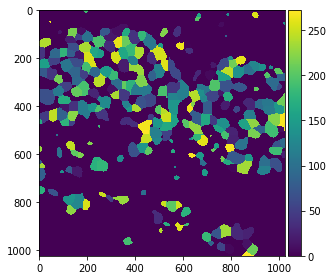

In [71]:
# Get input for overlay
input_data_xr = load_utils.load_imgs_from_multitiff(deepcell_input_dir,
                                                  multitiff_files=points_input)

# Overlaying the DNA
overlay_channels = [input_data_xr.channels.values]

warnings.simplefilter("ignore")

segmentation_utils.visualize_segmentation(
            segmentation_labels_xr=segmentation_labels,
            fovs=input_data_xr.fovs.values, channel_data_xr=input_data_xr,
            chan_list = overlay_channels[0], output_dir=label_dir)

In [73]:
print(input_data_xr.fovs.values)
print(overlay_channels)
segmentation_utils.visualize_segmentation(
            segmentation_labels_xr=segmentation_labels,
            fovs=[input_data_xr.fovs.values[0],input_data_xr.fovs.values[0]], channel_data_xr=input_data_xr,
            chan_list = overlay_channels[:2], output_dir=label_dir)

['Point8']
[array([0, 1], dtype=int64)]


TypeError: unhashable type: 'numpy.ndarray'

### Afterwards, we can generate expression matrices from the labeling + imaging data

Returns:
* cell_size_normalized_data: computed by dividing the marker counts in segmentation_labels by their corresponding cell size.
* arcsinh_transformed_data: first, linearly scale each value of cell_size_normalized_data by multiplying by 100. Then, pass the linearly scaled cell_size_normalized_data through the arcsinh function.

In [ ]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each FOV given it's own folder and all FOVs having the same channels
combined_cell_size_normalized_data, combined_arcsinh_transformed_data = \
    marker_quantification.compute_complete_expression_matrices(segmentation_labels=segmentation_labels,
                                                               tiff_dir=tiff_dir,
                                                               img_sub_folder="TIFs",
                                                               is_mibitiff=MIBItiff,
                                                               points=points,
                                                               batch_size=5)

In [ ]:
# specify the path to the single_cell_output folder, and create it if it doesn't already exist
# this is where we will store our combined_normalized_data and combined_transformed_data output
single_cell_dir = os.path.join(base_dir, "single_cell_output")

if not os.path.exists(single_cell_dir):
    os.makedirs(single_cell_dir)

In [ ]:
# save output as CSV
combined_cell_size_normalized_data.to_csv(os.path.join(single_cell_dir, 'cell_size_normalized_data.csv'), index=False)
combined_arcsinh_transformed_data.to_csv(os.path.join(single_cell_dir, 'arcsinh_transformed_data.csv'), index=False)